![xwrf Logo](https://xwrf.readthedocs.io/en/latest/_static/xwrf_logo_bg_light.svg "xwrf Logo")

# Introduction to xwrf

---

## Overview

This notebook will introduce the basics of gridded, labeled data with Xarray. Since Xarray introduces additional abstractions on top of plain arrays of data, our goal is to show why these abstractions are useful and how they frequently lead to simpler, more robust code.

We'll cover these topics:

1. Create a `DataArray`, one of the core object types in Xarray
1. Understand how to use named coordinates and metadata in a `DataArray`
1. Combine individual `DataArrays` into a `Dataset`, the other core object type in Xarray
1. Subset, slice, and interpolate the data using named coordinates
1. Open netCDF data using XArray
1. Basic subsetting and aggregation of a `Dataset`
1. Brief introduction to plotting with Xarray

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [NumPy Basics](https://foundations.projectpythia.org/core/numpy/numpy-basics.html) | Necessary |  |
| [Introduction to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Neccessary | Understanding of data structures |
| [Intermediate NumPy](https://foundations.projectpythia.org/core/numpy/intermediate-numpy.html) | Helpful | Familiarity with indexing and slicing arrays |
| [Datetime](https://foundations.projectpythia.org/core/datetime/datetime) | Helpful | Familiarity with time formats and the `timedelta` object |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |

- **Time to learn**: 30 minutes

---

## Imports

Simmilar to `numpy`, `np`; `pandas`, `pd`; you may often encounter `xarray` imported within a shortened namespace as `xr`.

In [23]:
from datetime import timedelta

import cmweather
import xarray as xr
import xwrf
import glob

import matplotlib.pyplot as plt

## Introducing xwrf

`xWRF` is a package designed to make the post-processing of [`WRF`](https://www.mmm.ucar.edu/weather-research-and-forecasting-model) output data more pythonic. It's aim is to smooth the rough edges around the unique, non CF-compliant [`WRF`](https://www.mmm.ucar.edu/weather-research-and-forecasting-model) output data format and make the data accessible to utilities like [`dask`](https://dask.org/) and the wider [Pangeo](https://pangeo.io/) universe.

It is built as an [Accessor](https://xarray.pydata.org/en/stable/internals/extending-xarray.html) on top of [`xarray`](https://xarray.pydata.org/en/stable/index.html), providing a very simple user interface.

### Finding a Dataset

Our dataset of interest is a WRF dataset from the SAIL domain, near Gothic, Colorado, available as an ARM PI dataset - https://iop.archive.arm.gov/arm-iop-file/2021/guc/sail/xu-wrf/README.html.

More information on the dataset:
	
```quote-block
These are the Weather Research and Forecasting (WRF) regional climate model simulations for supporting the analysis of temperature, precipitation, and other hydroclimate variables and evaluating SAIL data. The WRF model has three nested domains centered at the SAIL location (East River, Colorado) for the SAIL period from Oct 01, 2021 to Dec 31, 2022. We used the BSU subgrid-scale physics schemes, CFSR meteorological forcing datasets, and the topographic shading radiation schemes in our WRF simulation. Detailed information on the model configuration can be found at https://doi.org/10.5194/egusphere-2022-437
```

### Examining the data

When opening up a normal [`WRF`](https://www.mmm.ucar.edu/weather-research-and-forecasting-model) output file with the simple [`xarray`](https://docs.xarray.dev/en/stable/#) netcdf backend, one can see that it does not provide a lot of useful information.

In [3]:
ds = xr.open_dataset("../data/sail/wrf/wrfout_d03_2023-03-10_00_00_00")
ds

<xarray.Dataset> Size: 216MB
Dimensions:                (Time: 1, south_north: 201, west_east: 201,
                            bottom_top: 49, bottom_top_stag: 50,
                            soil_layers_stag: 4, west_east_stag: 202,
                            south_north_stag: 202, seed_dim_stag: 2,
                            snow_layers_stag: 3, snso_layers_stag: 7)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 162kB ...
    XLONG                  (Time, south_north, west_east) float32 162kB ...
    XTIME                  (Time) datetime64[ns] 8B ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 162kB ...
    XLONG_U                (Time, south_north, west_east_stag) float32 162kB ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 162kB ...
    XLONG_V                (Time, south_north_stag, west_east) float32 162kB ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag,
                                seed_dim_stag, snow_layers_stag,
                                snso_layers_stag
Data variables: (12/351)
    Times                  (Time) |S19 19B ...
    LU_INDEX               (Time, south_north, west_east) float32 162kB ...
    ZNU                    (Time, bottom_top) float32 196B ...
    ZNW                    (Time, bottom_top_stag) float32 200B ...
    ZS                     (Time, soil_layers_stag) float32 16B ...
    DZS                    (Time, soil_layers_stag) float32 16B ...
    ...                     ...
    PCB                    (Time, south_north, west_east) float32 162kB ...
    PC                     (Time, south_north, west_east) float32 162kB ...
    LANDMASK               (Time, south_north, west_east) float32 162kB ...
    LAKEMASK               (Time, south_north, west_east) float32 162kB ...
    SST                    (Time, south_north, west_east) float32 162kB ...
    SST_INPUT              (Time, south_north, west_east) float32 162kB ...
Attributes: (12/153)
    TITLE:                            OUTPUT FROM WRF V4.4 MODEL
    START_DATE:                      2023-02-27_00:00:00
    SIMULATION_START_DATE:           2021-09-15_00:00:00
    WEST-EAST_GRID_DIMENSION:        202
    SOUTH-NORTH_GRID_DIMENSION:      202
    BOTTOM-TOP_GRID_DIMENSION:       50
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

### Use `.postprocess()` to clean the dataset
While all variables are present, e.g. the information about the projection is still in the metadata and also for some fields, there are non-[`metpy`](https://unidata.github.io/MetPy/latest/index.html) compliant units attributes.

So let's try to use the standard `xWRF.postprocess()` function in order to make this information useable.

In [4]:
ds = xr.open_dataset("../data/sail/wrf/wrfout_d03_2023-03-10_00_00_00").xwrf.postprocess()
ds

<xarray.Dataset> Size: 224MB
Dimensions:                    (Time: 1, y: 201, x: 201, soil_layers_stag: 4,
                                z: 49, x_stag: 202, y_stag: 202, z_stag: 50,
                                seed_dim_stag: 2, snow_layers_stag: 3,
                                snso_layers_stag: 7)
Coordinates: (12/15)
    XLAT                       (y, x) float32 162kB 38.39 38.39 ... 39.3 39.3
    XLONG                      (y, x) float32 162kB -107.6 -107.6 ... -106.5
    XTIME                      (Time) datetime64[ns] 8B ...
    XLAT_U                     (y, x_stag) float32 162kB 38.39 38.39 ... 39.3
    XLONG_U                    (y, x_stag) float32 162kB -107.6 ... -106.4
    XLAT_V                     (y_stag, x) float32 162kB 38.38 38.38 ... 39.3
    ...                         ...
  * z_stag                     (z_stag) float32 200B 1.0 0.9935 ... 0.006181 0.0
  * Time                       (Time) datetime64[ns] 8B 2023-03-10
  * x                          (x) float64 2kB -5.344e+04 ... 4.656e+04
  * x_stag                     (x_stag) float64 2kB -5.369e+04 ... 4.681e+04
  * y_stag                     (y_stag) float64 2kB -5.625e+04 ... 4.425e+04
  * y                          (y) float64 2kB -5.6e+04 -5.55e+04 ... 4.4e+04
Dimensions without coordinates: soil_layers_stag, seed_dim_stag,
                                snow_layers_stag, snso_layers_stag
Data variables: (12/352)
    Times                      (Time) |S19 19B b'2023-03-10_00:00:00'
    LU_INDEX                   (Time, y, x) float32 162kB ...
    ZS                         (Time, soil_layers_stag) float32 16B ...
    DZS                        (Time, soil_layers_stag) float32 16B ...
    VAR_SSO                    (Time, y, x) float32 162kB ...
    BATHYMETRY_FLAG            (Time) int32 4B ...
    ...                         ...
    geopotential_height        (Time, z_stag, y, x) float32 8MB 2.74e+03 ... ...
    wind_east                  (Time, z, y, x) float32 8MB 3.388 3.657 ... 25.5
    wind_north                 (Time, z, y, x) float32 8MB 2.574 ... -5.884
    wind_east_10               (Time, y, x) float32 162kB 2.603 3.164 ... 6.027
    wind_north_10              (Time, y, x) float32 162kB 1.978 ... -0.3557
    wrf_projection             object 8B +proj=lcc +x_0=0 +y_0=0 +a=6370000 +...
Attributes: (12/153)
    TITLE:                            OUTPUT FROM WRF V4.4 MODEL
    START_DATE:                      2023-02-27_00:00:00
    SIMULATION_START_DATE:           2021-09-15_00:00:00
    WEST-EAST_GRID_DIMENSION:        202
    SOUTH-NORTH_GRID_DIMENSION:      202
    BOTTOM-TOP_GRID_DIMENSION:       50
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

As you see, `xWRF` added some coordinate data, reassigned some dimensions and generally increased the amount of information available in the dataset.

### Plot the Data!

Now that we have our data in an easier to analyze format, let's plot one of the fields.

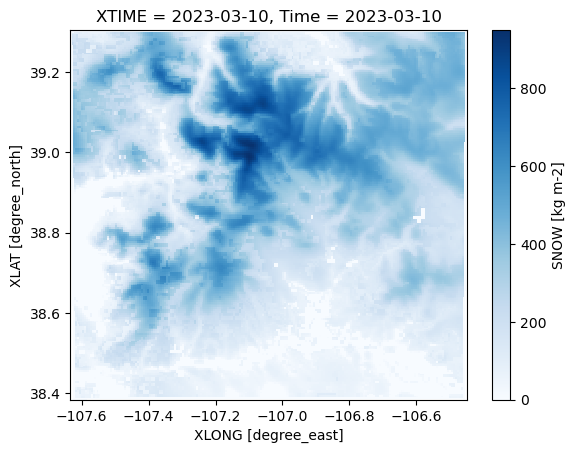

In [12]:
ds.SNOW.plot(x='XLONG',
             y='XLAT',
             cmap='Blues')

## Investigate the change in SWE over time

In [15]:
first_ds = xr.open_dataset("../data/sail/wrf/wrfout_d03_2023-03-10_00_00_00").xwrf.postprocess().squeeze()
last_ds = xr.open_dataset("../data/sail/wrf/wrfout_d03_2023-03-11_00_00_00").xwrf.postprocess().squeeze()

### Calculate the Change in SWE
Here, we take the difference using Xarray!

In [17]:
difference = last_ds["SNOW"] - first_ds["SNOW"]

In [27]:
last_ds["SNOW"]

<xarray.DataArray 'SNOW' (y: 201, x: 201)> Size: 162kB
[40401 values with dtype=float32]
Coordinates:
    XLAT     (y, x) float32 162kB 38.39 38.39 38.39 38.39 ... 39.3 39.3 39.3
    XLONG    (y, x) float32 162kB -107.6 -107.6 -107.6 ... -106.5 -106.5 -106.5
    XTIME    datetime64[ns] 8B ...
    CLAT     (y, x) float32 162kB 38.39 38.39 38.39 38.39 ... 39.3 39.3 39.3
    Time     datetime64[ns] 8B 2023-03-11
  * x        (x) float64 2kB -5.344e+04 -5.294e+04 ... 4.606e+04 4.656e+04
  * y        (y) float64 2kB -5.6e+04 -5.55e+04 -5.5e+04 ... 4.35e+04 4.4e+04
Attributes:
    FieldType:     104
    MemoryOrder:   XY 
    description:   SNOW WATER EQUIVALENT
    units:         kg m-2
    stagger:       
    grid_mapping:  wrf_projection

Text(0.5, 1.0, '24 Hour Difference in \n Snow Water Liquid Equivalent \n 10 March to 11 March 2023')

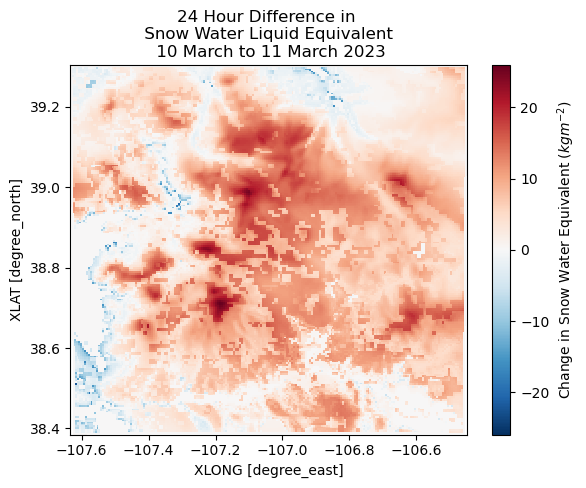

In [35]:
difference.plot(x='XLONG',
                y='XLAT',
                cbar_kwargs={'label': "Change in Snow Water Equivalent ($kgm^{-2}$)"})
plt.title("24 Hour Difference in \n Snow Water Liquid Equivalent \n 10 March to 11 March 2023")

## Challenge: Why is there more snow in some areas, and less in others?
- Investigate other fields in the datasets
- Look at other time steps - where are our precipitation fields?
- Find possible scientific explanations here!

In [36]:
files = sorted(glob.glob("../data/sail/wrf/*"))
files

['../data/sail/wrf/wrfout_d03_2023-03-10_00_00_00',
 '../data/sail/wrf/wrfout_d03_2023-03-10_06_00_00',
 '../data/sail/wrf/wrfout_d03_2023-03-10_12_00_00',
 '../data/sail/wrf/wrfout_d03_2023-03-10_18_00_00',
 '../data/sail/wrf/wrfout_d03_2023-03-11_00_00_00']

---

## Summary

xwrf can be a helpful tool when working with WRF data in Python! In this tutorial, we investigated WRF data from the SAIL campaign, digging into the datasets and using visualization techniques to analyze our results.

### What's next?

How do we scale up this analysis beyond a 24 hour run? Or higher resolution data? In future notebooks, we explore tools to help with increasing our ability to analyze high resolution datasets with xwrf.

## Resources and references

This notebook was adapated from material in [xwrf Documentation](https://xwrf.readthedocs.io/).

The dataset used here is an ARM PI dataset, courtesy of Zexuan Xu (zexuanxu@lbl.gov). If you use this dataset, please be sure to cite:
- https://doi.org/10.5439/1971597
- More information can be found in the related publication - https://doi.org/10.5194/egusphere-2022-437